In [11]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import math
import os

def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    return df_master

def species_plot(df):
    df = df.replace("__ribosome", "free ribosomes")
    df = df.replace("TTT_charged", "charged tRNA")
    df = df.replace("TTT_uncharged", "uncharged tRNA")
    df_fil = df[(df.species == "charged tRNA") | (df.species == "free ribosomes")]
    g = sns.lineplot(x="time", y="protein", units="seed", hue="species", estimator=None, data=df_fil)
    g.get_legend().set_title(None)

In [12]:
from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before

def get_average_protein(path_pref, time, max_seed):
    df_master = pd.read_csv(f"{path_pref}_1.tsv")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    # get average species counts for all trials
    df_master = df_master.groupby(["time", "species"])["protein"].mean().reset_index()
    if time not in df_master["time"].values:
        time = take_closest(df_master["time"].values, time)
        print(time)
    df_master = df_master[(df_master.time == time)] 
    df_master = df_master.replace("__ribosome", "ribosomes")
    return df_master

In [13]:
from trnasimtools.serialize import SerializeSingleCodonSingleTranscript
from trnasimtools.simulate import SimulateSingleCodonSingleTranscript

In [14]:
rcParams['figure.figsize'] = [10, 5]

In [2]:
!mkdir ../yaml/april-15-2023
!mkdir ../output/april-15-2023

In [13]:
date = "april-15-2023"

## Finding analytical solutions for a single codon/single transcript system

This system consists of a fixed pool of mRNA transcripts, ribosomes, and a single type of tRNA. The rate of protein production depends exclusively on the steady-state concentrations of free ribosomes and charged tRNAs. We will attempt to find analytical solutions to calculate these quantities.

For tRNAs, the conversion between the charged/aminoacylated and uncharged form occurs instantaneously and irreversibly. Generically, this kind of reaction looks like

$A \rightarrow B$ with rate $k_{+}$ and $B \rightarrow A$ with rate $k_{-}$

The correspnding rate equation is

$\frac{d}{dt}\ a(t) = k_{-}b(t) - k_{+}a(t)$ 

and 

$\frac{d}{dt}\ b(t) = k_{+}a(t) - k_{-}b(t)$

Since total concentration is conserved, the concentrations can be derived by writing

$b(t) = T - a(t)$

Where $T$ is the total concentration of the reversible species. Equation 1 can then be re-written as   

$\frac{d}{dt}\ a(t) = k_{-}(T - a(t)) - k_{+}a(t)$

and

$\frac{d}{dt}\ a(t) = k_{-}T - (k_{+} + k_{-})a(t)$ 

The steady-state concentration satisfies 
$0 = k_{-}T - (k_{+} + k_{-})a(t)$

Solving gives
$$
a^{ss} = \frac {k_{-}T}{k_{+}+k_{-}} 
$$

The rate of consumption of charged tRNAs depends on the number of actively translating ribosomes (I think) -> so, the steady-state concentration of active ribosomes, and the ribosome "speed" constant. And then the rate of production depends on the charging rate constant. So if we let charged tRNAs be $a^{ss}$, swapping these in to the generic steady-state equation we have

$$
    tRNA_{charged}^{ss} = \frac{tRNA_{tot}*k_{charge}}{rib_{active}^{ss} * k_{speed} + k_{charge}}\
$$    

$$
    rib_{active}^{ss} = \frac{rib_{tot}*k_{bind}*mRNA_{copy}}{\frac{tRNA_{charged}^{ss}}{mRNA_{copy}*len}\ + k_{bind}*mRNA_{copy}}\
$$

Next, I run a simulation where active ribosomes and tRNAs have non-trivial (not 0 or max) steady-states, and check the simulated charged tRNA quantities against abundances calculated from the above equation.

In [14]:
TS_COPY = 200
RBS_STRENGTH = 10000
TRNA_CHRG_RATE = 100
RB_COPY = 100
TOTAL_TRNA = 100
TIME_LIMIT = 500
TIME_STEP = 5

In [6]:
serializer = SerializeSingleCodonSingleTranscript(transcript_len=100,
                                                   transcript_copy_number=TS_COPY,
                                                   ribosome_binding_rate=RBS_STRENGTH,
                                                   ribosome_copy_number=RB_COPY,
                                                   total_trna=TOTAL_TRNA,
                                                   trna_charging_rate=TRNA_CHRG_RATE
                                                   )
serializer.serialize(f"../yaml/{date}")

In [12]:
configs = f"../yaml/{date}/{serializer.filename()}"
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    cmd = f"python3 singlecodonsingletranscript.py {config} 1 ../output/{date} {TIME_LIMIT} {TIME_STEP}"
    stream.write(cmd)
    stream.write("\n")

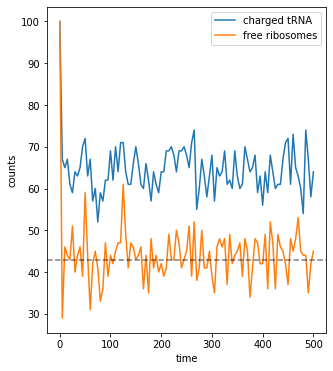

In [20]:
# Read in the simualtion and plot the analytical solution 
rcParams['figure.figsize'] = [5, 6]
df_master = read_sim("../output/april-15-2023/two_codon_single_transcript_200_100_100_10000_100", 1, 1, 1) #should be "one codon"
species_plot(df_master)
#ribosome_plot(df_master)
plt.ylabel("counts")
plt.gca().axhline(43, ls='--', color="black", alpha=0.5)
#plt.gca().axhline(64, ls='--', color="black", alpha=0.5)
plt.savefig(f"../plots/april-15-2023/rbs_10000_chrg_100_rib_line_short.png", bbox_inches="tight")

This seems to work. Next, I will do the same calculation but for a series of simulations with charging rates ranging from 10^0 to 10^4

In [7]:
chrg_rates = [1.0, 2.5, 5.0, 7.5, 10.0, 25.0, 50.0, 75.0, 100.0, 250.0, 500.0, 750.0, 1000.0, 2500.0, 5000.0, 7500.0, 10000.0]
for rate in chrg_rates:
    serializer = SerializeSingleCodonSingleTranscript(transcript_len=100,
                                                       transcript_copy_number=TS_COPY,
                                                       ribosome_binding_rate=RBS_STRENGTH,
                                                       ribosome_copy_number=RB_COPY,
                                                       total_trna=TOTAL_TRNA,
                                                       trna_charging_rate=rate
                                                       )
    serializer.serialize(f"../yaml/{date}")

In [19]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for seed in range(1, 4):
            cmd = f"python3 singlecodonsingletranscript.py ../yaml/{date}/{config} {seed} ../output/{date} {TIME_LIMIT} {TIME_STEP} {RB_SPEED}"
            stream.write(cmd)
            stream.write("\n")

In [149]:
chrg_rates = [1.0, 2.5, 5.0, 7.5, 10.0, 25.0, 50.0, 75.0, 100.0, 250.0, 500.0, 750.0, 1000.0, 2500.0, 5000.0, 7500.0, 10000.0]
df_master = None
for rate in chrg_rates:
    path = f"../output/{date}/single_codon_single_transcript_200_100_100_10000_{rate}"
    tmp = get_average_protein(path, 500, 3)
    tmp["charging_rate"] = rate
    df_master = tmp if df_master is None else df_master.append(tmp, ignore_index=True)
df_master

496.0
495.0


,time,species,protein,charging_rate
0,496.0,TTT_charged,0.5,1.0
1,496.0,TTT_uncharged,99.5,1.0
2,496.0,__proteinX_rbs,193.0,1.0
3,496.0,ribosomes,1.5,1.0
4,496.0,proteinX,439.5,1.0
...,...,...,...,...
80,500.0,TTT_charged,99.0,10000.0
81,500.0,TTT_uncharged,1.0,10000.0
82,500.0,__proteinX_rbs,199.0,10000.0
83,500.0,ribosomes,79.5,10000.0


In [150]:
df_rib_only = df_master[(df_master.species == "ribosomes")]

df_filtered = df_master[(df_master.species == "TTT_charged") | (df_master.species == "ribosomes")]
df_filtered = df_filtered.pivot(index = "charging_rate", columns = "species", values = "protein").reset_index()
df_filtered["tRNA predicted"] = (100 * df_filtered["charging_rate"]) / (((100 - df_filtered["ribosomes"]) * 3) + df_filtered["charging_rate"])
df_filtered = pd.melt(df_filtered, id_vars=["charging_rate"], value_vars=["TTT_charged", "tRNA predicted"])

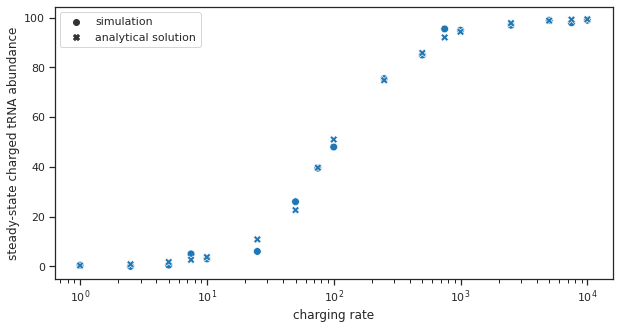

In [143]:
rcParams['figure.figsize'] = [10, 5]
sns.set_theme(style="ticks", palette=None)

df_filtered = df_filtered.replace("TTT_charged", "simulation")
df_filtered = df_filtered.replace("tRNA predicted", "analytical solution")
g = sns.scatterplot(data=df_filtered, x="charging_rate", y="value", style="species", s=60)
g.get_legend().set_title(None)
plt.xscale("log")
plt.ylabel("steady-state charged tRNA abundance")
plt.xlabel("charging rate")
#plt.savefig(f"../plots/april-15-2023/steady_state_ranges.png", bbox_inches="tight")

Text(0.5, 0, 'charging rate')

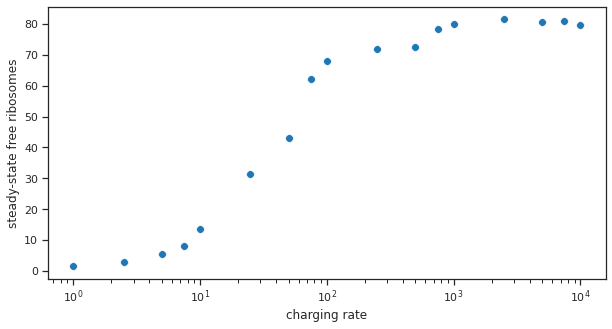

In [152]:
rcParams['figure.figsize'] = [10, 5]
sns.set_theme(style="ticks", palette=None)

g = sns.scatterplot(data=df_rib_only, x="charging_rate", y="protein", s=60)
plt.xscale("log")
plt.ylabel("steady-state free ribosomes")
plt.xlabel("charging rate")

~~Now for ribosomes. The rate of consumption of free ribosomes should be proportional to the initiation/binding rate constant and the number of binding sites. The rate of production (replenishing the free ribosome pool) depends on how long elongation takes, which should be proportional to the number of charged tRNAS and inversely proportional to the length of the mRNA. Subsituting these we get~~

$$
    rib_{free}^{ss} = \frac{rib_{tot}*tRNA_{charged}^{ss}*mRNA_{len}^{-1}}{mRNA_{tot}*k_{bind} + tRNA_{charged}^{ss}*mRNA_{len}^{-1}}\
$$

$$
    tRNA_{charged}^{ss} = tRNA_{tot}*\frac{k_{charge}}{rib_{active}^{ss} * k_{speed} + k_{charge}}\
$$

$$
    tRNA_{charged}^{ss} = \frac{tRNA_{tot}*k_{charge}}{(rib_{total} - rib_{free}^{ss}) * k_{speed} + k_{charge}}\
$$

$$
    tRNA_{charged}^{ss} = 100*\frac{100}{(100-45) * 1 + 100}\ \approx 65
$$

\begin{align}
rib_{free}^{ss} & = \frac{rib_{tot}*tRNA_{charged}^{ss}*mRNA_{len}^{-1}}{mRNA_{tot}*k_{bind} + tRNA_{charged}^{ss}*mRNA_{len}^{-1}}\ \\
tRNA_{charged}^{ss} & = tRNA_{tot}*\frac{k_{charge}}{rib_{active}^{ss} * k_{speed} + k_{charge}}\
\end{align} 

$$
rib_{free}*k_{bind}*mRNA = \frac{rib_{active}*tRNA_{charged}}{mRNA*len}\
$$

$$
rib_{active} = rib_{tot} * \frac{k_{bind}*mRNA}{\frac{tRNA_{charged}}{mRNA*len}\ + k_{bind}*mRNA}\
$$

$$
rib_{active} = 100 * \frac{0.000021*200}{\frac{64}{200*100}\ + 0.000021*200}\ \approx 57
$$


$$
    tRNA_{charged} = tRNA_{tot} * \frac{k_{charge}}{rib_{active} * k_{speed} + k_{charge}}\
$$    

$$
    tRNA_{charged} = 100*\frac{100}{57 * 1 + 100}\ \approx 64
$$

In [ ]:
.0074 = 56